# Activity in class (Image Classification)

This notebook implements the task **(Image Classification on CIFAR-10)**:

- (a) Logistic regression (no hidden layers)
- (b) Fully-connected network with 1 hidden layer
- (c) Convolutional neural network with max-pooling and fully-connected output

It is structured to be **Colab-ready**, with clear sections, explanations, and GPU support.

# **Image Classification on CIFAR-10**

In this problem, we will explore different deep learning architectures for classifying images from the CIFAR-10 dataset. The objective is to train models with different network architectures and evaluate their performance on the CIFAR-10 dataset.

## **Task Overview**

### **1. Data**
- CIFAR-10 dataset consists of 32×32 RGB images belonging to 10 classes.
- The network should predict the class label for each image.

### **2. Models to Build**
- **Part (a)**: Logistic Regression (no hidden layers)
  - A simple model that maps the 32×32×3 input image directly to a 10-dimensional output (logits).
  
- **Part (b)**: Fully-Connected Network with 1 Hidden Layer
  - This model uses a single hidden layer with ReLU activation and outputs 10 class predictions.
  
- **Part (c)**: Convolutional Neural Network (CNN)
  - This model applies a convolutional layer followed by a max-pooling layer and a fully-connected output layer to classify images.

## **Steps to Complete**

### **1. Preprocessing**
- Load and normalize the CIFAR-10 dataset.
- Split the dataset into training and validation sets.

### **2. Hyperparameter Tuning**
- Use techniques like random search or grid search to find the best hyperparameters (e.g., learning rate, number of units in hidden layers, etc.).

### **3. Model Evaluation**
- For each architecture (logistic regression, fully-connected, and CNN), evaluate the training and validation accuracies.
- Plot the training and validation accuracies for the top 5 hyperparameter configurations.

### **4. Final Evaluation**
- After training, evaluate the best model on the test dataset and report the test accuracy.

### **5. Submission**
- Submit the code, along with the hyperparameter configurations and the test accuracy of the best-performing models.

## **Key Requirements**
- **Logistic Regression**: A model with no hidden layers.
- **Fully-Connected Network**: One hidden layer, apply ReLU activation.
- **CNN**: Conv2D layer, ReLU activation, max-pooling, and fully-connected output.

## **Evaluation**
- What is the highest accuracy that you raise?


## 1. Environment Setup (GPU, Libraries)

This section:
- Imports all necessary libraries
- Detects whether a GPU is available
- Sets a random seed for reproducibility

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# For reproducibility (you can change the seed if you want)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Detect device (MPS for Apple Silicon, CUDA for NVIDIA, or CPU)
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using device: MPS (Apple Silicon GPU)')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(SEED)
    print('Using device: CUDA')
else:
    device = torch.device('cpu')
    print('Using device: CPU')

print(f'Device: {device}')

Using device: MPS (Apple Silicon GPU)
Device: mps


## 2. Data Loading and Preprocessing (CIFAR-10)

This section:
- Downloads CIFAR-10 (if needed)
- Applies basic normalization
- Splits the original training set into **train** and **validation** sets
- Prepares the **test** set

We will use:
- 45,000 samples for training
- 5,000 samples for validation
- 10,000 samples for testing

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

BATCH_SIZE = 128  # You can tune this if you want

# Transformations: convert to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load full training set and test set
train_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set   = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create train/validation split
val_size = 5000
train_size = len(train_full) - val_size
train_set, val_set = random_split(train_full, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

len(train_set), len(val_set), len(test_set)

(45000, 5000, 10000)

## 3. Training and Evaluation Utilities

Here we define helper functions to:
- Train one epoch (`train_one_epoch`)
- Evaluate accuracy and loss on a dataset (`evaluate`)

Both functions work for any model that takes an image batch and outputs logits of shape `(batch_size, 10)`.

In [3]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        _, pred = output.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    return correct / total, total_loss / total

def evaluate(model, loader, loss_fn):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = loss_fn(output, y)

            total_loss += loss.item() * x.size(0)
            _, pred = output.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)
    return correct / total, total_loss / total

## 4. Models

We implement the three required architectures:

### 4.1 Logistic Regression (Part a)
- Flatten image: 32×32×3 = 3072
- Linear layer: 3072 → 10

### 4.2 Fully-Connected Network with 1 Hidden Layer (Part b)
- Flatten image: 3072
- Linear: 3072 → M
- ReLU
- Linear: M → 10

### 4.3 Convolutional Network (Part c)
- Conv2d: input 3 channels, output M filters, kernel size k
- ReLU
- MaxPool2d with window N×N
- Flatten
- Linear to 10 classes

In [4]:
class LogisticRegression(nn.Module):
    """Part (a): Logistic regression model with no hidden layers."""
    def __init__(self, M=100, k=5, pool=5):
        super().__init__()
        self.fc = nn.Linear(3072, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 3072)
        return self.fc(x)


class FC1(nn.Module):
    """Part (b): Fully-connected network with one hidden layer of size M."""
    def __init__(self, M=256):
        super().__init__()
        self.fc1 = nn.Linear(3072, M)
        self.fc2 = nn.Linear(M, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 3072)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class SimpleConvNet(nn.Module):
    """Part (c): Conv layer + ReLU + MaxPool + Fully-connected."""
    def __init__(self, M=64, k=5, pool=2):
        super().__init__()
        self.conv = nn.Conv2d(3, M, kernel_size=k)
        self.pool = nn.MaxPool2d(kernel_size=pool)
        
        # Calculate the size after conv and pooling
        # Input: 32x32, after conv with kernel k: (32-k+1), after pool: (32-k+1)/pool
        conv_out_size = (32 - k + 1) // pool
        self.fc = nn.Linear(M * conv_out_size * conv_out_size, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

## 5. Generic Experiment Runner

To avoid repeating code, we define a generic function `run_experiment` that:
- Creates the model
- Sets up the optimizer
- Trains for a given number of epochs
- Records training and validation accuracy at each epoch
- Prints progress along the way

We will reuse this function for all three parts (a), (b), and (c).

In [5]:
def run_experiment(model_fn, params, epochs=12, train_loader=train_loader, val_loader=val_loader):
    """Run one training experiment.
    model_fn: function that builds a model with no arguments.
    params: dictionary containing hyperparameters (must at least have 'lr').
    """
    lr = params.get("lr", 0.01)
    model = model_fn().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()

    train_accs, val_accs = [], []

    for ep in range(epochs):
        train_acc, train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
        val_acc, val_loss     = evaluate(model, val_loader, loss_fn)

        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {ep+1:02d} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    return model, train_accs, val_accs

## 6. Part (a): Logistic Regression — Hyperparameter Search

We will:
1. Define a small set of learning rates to try.
2. Train one logistic regression model per configuration.
3. Record training and validation accuracy curves.
4. Later, we will plot all curves together and evaluate the best configuration on the test set.

In [6]:
NUM_EPOCHS_A = 10  # you can increase if you want better performance

logreg_configs = [
    {"lr": 0.1},
    {"lr": 0.05},
    {"lr": 0.01},
    {"lr": 0.005},
    {"lr": 0.001},
]

results_logreg = []

for cfg in logreg_configs:
    print("\n=== Logistic Regression config:", cfg, "===")
    model, ta, va = run_experiment(lambda: LogisticRegression(), cfg, epochs=NUM_EPOCHS_A)
    results_logreg.append((cfg, model, ta, va))


=== Logistic Regression config: {'lr': 0.1} ===
Epoch 01 | train_acc=0.2730 | val_acc=0.2962 | train_loss=4.5208 | val_loss=4.6956
Epoch 02 | train_acc=0.2995 | val_acc=0.2836 | train_loss=4.2698 | val_loss=4.2263
Epoch 03 | train_acc=0.3014 | val_acc=0.2926 | train_loss=4.2341 | val_loss=4.8199
Epoch 04 | train_acc=0.3009 | val_acc=0.3186 | train_loss=4.5697 | val_loss=4.8070
Epoch 05 | train_acc=0.3068 | val_acc=0.2754 | train_loss=4.3141 | val_loss=5.0817
Epoch 06 | train_acc=0.3112 | val_acc=0.2794 | train_loss=4.2708 | val_loss=4.8311
Epoch 07 | train_acc=0.3175 | val_acc=0.2988 | train_loss=4.2010 | val_loss=4.0664
Epoch 08 | train_acc=0.3159 | val_acc=0.2966 | train_loss=4.2242 | val_loss=4.5518
Epoch 09 | train_acc=0.3147 | val_acc=0.2902 | train_loss=4.2597 | val_loss=4.9992
Epoch 10 | train_acc=0.3181 | val_acc=0.2536 | train_loss=4.1877 | val_loss=4.1792

=== Logistic Regression config: {'lr': 0.05} ===
Epoch 01 | train_acc=0.2951 | val_acc=0.2992 | train_loss=2.6570 | val_

## 7. Part (b): 1 Hidden Layer Fully-Connected Network — Hyperparameter Search

We now consider networks with one hidden layer of size `M`.

We will tune:
- Hidden size `M`
- Learning rate `lr`

Goal: reach **at least 50% validation accuracy** for some configuration.

In [7]:
NUM_EPOCHS_B = 10  # you can increase for better accuracy

fc_configs = [
    {"lr": 0.1,   "M": 256},
    {"lr": 0.05,  "M": 512},
    {"lr": 0.01,  "M": 1024},
    {"lr": 0.005, "M": 512},
    {"lr": 0.001, "M": 256},
]

#fc_configs = [
#    {"lr": 0.1,   "M": 256},
#    {"lr": 0.05,  "M": 512},
#]

results_fc = []

for cfg in fc_configs:
    print("\n=== FC1 config:", cfg, "===")
    model, ta, va = run_experiment(lambda: FC1(cfg["M"]), cfg, epochs=NUM_EPOCHS_B)
    results_fc.append((cfg, model, ta, va))


=== FC1 config: {'lr': 0.1, 'M': 256} ===
Epoch 01 | train_acc=0.3196 | val_acc=0.3552 | train_loss=2.2844 | val_loss=2.1944
Epoch 02 | train_acc=0.3478 | val_acc=0.3448 | train_loss=2.3771 | val_loss=2.4024
Epoch 03 | train_acc=0.3659 | val_acc=0.3602 | train_loss=2.3435 | val_loss=2.1824
Epoch 04 | train_acc=0.3851 | val_acc=0.3688 | train_loss=2.1044 | val_loss=2.3660
Epoch 05 | train_acc=0.3961 | val_acc=0.3790 | train_loss=2.0864 | val_loss=2.2878
Epoch 06 | train_acc=0.3972 | val_acc=0.3724 | train_loss=2.0839 | val_loss=2.1795
Epoch 07 | train_acc=0.4130 | val_acc=0.3718 | train_loss=1.9947 | val_loss=2.2326
Epoch 08 | train_acc=0.4290 | val_acc=0.4056 | train_loss=1.8945 | val_loss=2.0552
Epoch 09 | train_acc=0.4404 | val_acc=0.4146 | train_loss=1.8799 | val_loss=2.0288
Epoch 10 | train_acc=0.4421 | val_acc=0.3942 | train_loss=1.8773 | val_loss=2.0728

=== FC1 config: {'lr': 0.05, 'M': 512} ===
Epoch 01 | train_acc=0.3925 | val_acc=0.4352 | train_loss=1.7451 | val_loss=1.6895


## 8. Part (c): Convolutional Network — Hyperparameter Search

We now consider a simple CNN:
- Conv2d → ReLU → MaxPool2d → Flatten → Linear

We will tune:
- Number of filters `M`
- Learning rate `lr`
- (You can also change `k` and `pool` if you like, but here we fix `k=5`, `pool=14`.)

Goal: reach **at least 65% validation accuracy** for some configuration.

In [8]:
NUM_EPOCHS_C = 10  # you can increase for better performance

conv_configs = [
    {"lr": 0.1,   "M": 64},
    {"lr": 0.05,  "M": 100},
    {"lr": 0.01,  "M": 128},
    {"lr": 0.005, "M": 100},
    {"lr": 0.001, "M": 64},
]

#conv_configs = [
#    {"lr": 0.1,   "M": 64},
#    {"lr": 0.05,  "M": 100},
#]

results_conv = []

for cfg in conv_configs:
    print("\n=== ConvNet config:", cfg, "===")
    model, ta, va = run_experiment(lambda: SimpleConvNet(M=cfg["M"], k=5, pool=14), cfg, epochs=NUM_EPOCHS_C)
    results_conv.append((cfg, model, ta, va))


=== ConvNet config: {'lr': 0.1, 'M': 64} ===
Epoch 01 | train_acc=0.4245 | val_acc=0.4728 | train_loss=1.6180 | val_loss=1.5279
Epoch 02 | train_acc=0.5114 | val_acc=0.4792 | train_loss=1.4211 | val_loss=1.5670
Epoch 03 | train_acc=0.5226 | val_acc=0.4540 | train_loss=1.3885 | val_loss=1.6380
Epoch 04 | train_acc=0.5404 | val_acc=0.5154 | train_loss=1.3512 | val_loss=1.4022
Epoch 05 | train_acc=0.5460 | val_acc=0.5184 | train_loss=1.3422 | val_loss=1.4173
Epoch 06 | train_acc=0.5469 | val_acc=0.5536 | train_loss=1.3331 | val_loss=1.2988
Epoch 07 | train_acc=0.5547 | val_acc=0.5070 | train_loss=1.3115 | val_loss=1.4947
Epoch 08 | train_acc=0.5564 | val_acc=0.5540 | train_loss=1.3088 | val_loss=1.3253
Epoch 09 | train_acc=0.5617 | val_acc=0.5404 | train_loss=1.3021 | val_loss=1.3711
Epoch 10 | train_acc=0.5676 | val_acc=0.5494 | train_loss=1.2875 | val_loss=1.3347

=== ConvNet config: {'lr': 0.05, 'M': 100} ===
Epoch 01 | train_acc=0.4261 | val_acc=0.5236 | train_loss=1.5997 | val_loss=

## 9. Plotting Training and Validation Accuracy Curves

The homework asks for plots of **training** and **validation** classification accuracy as a function of epoch,
for the **top 5 configurations** for each part.

Here we define a helper function to generate such plots.

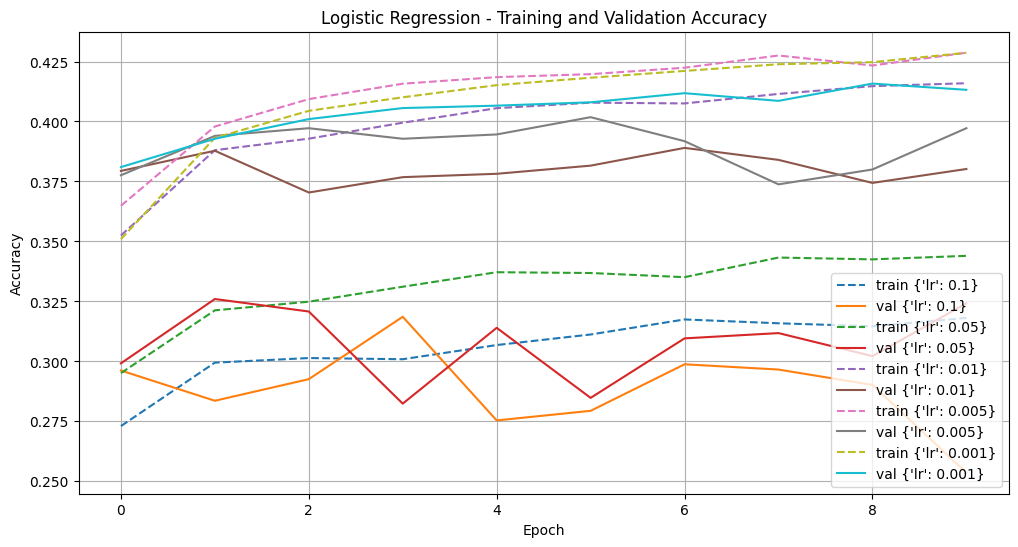

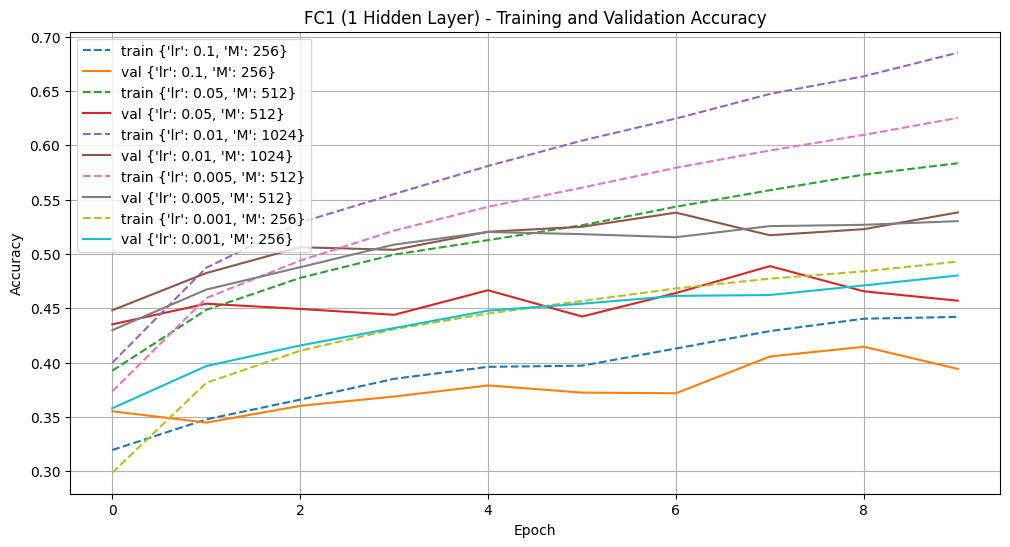

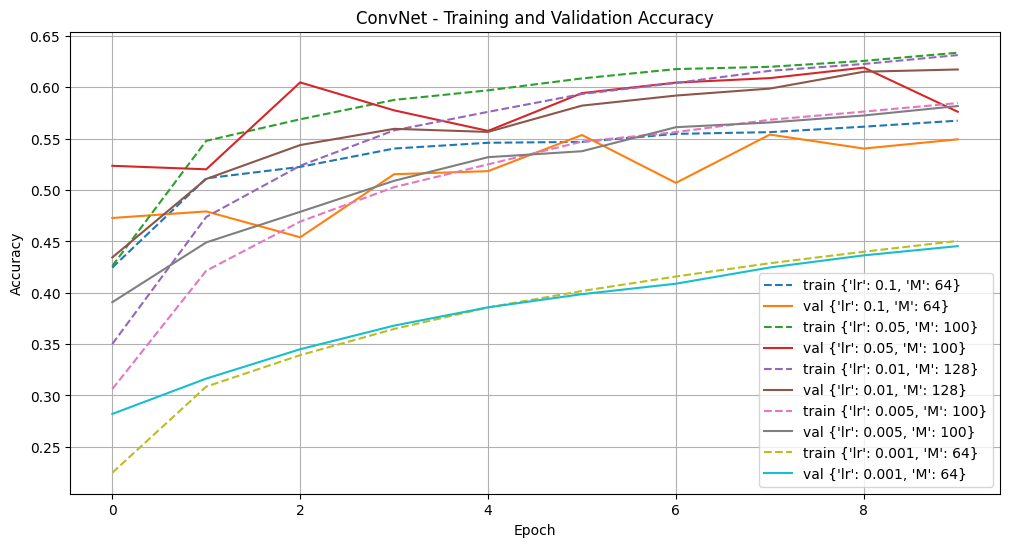

In [11]:
def plot_results(results, title):
    plt.figure(figsize=(12, 6))
    for cfg, _, train_acc, val_acc in results:
        label = str(cfg)
        plt.plot(train_acc, linestyle='--', label=f"train {label}")
        plt.plot(val_acc, label=f"val {label}")
    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

plot_results(results_logreg, "Logistic Regression - Training and Validation Accuracy")
plot_results(results_fc, "FC1 (1 Hidden Layer) - Training and Validation Accuracy")
plot_results(results_conv, "ConvNet - Training and Validation Accuracy")

## 10. Selecting Best Hyperparameters and Evaluating on Test Set

For each family of models (logistic regression, FC1, ConvNet), we:
- Select the configuration with **highest validation accuracy**.
- Evaluate the corresponding model on the **test set**.
- Report the test accuracy.

In [10]:
def evaluate_best_on_test(results, name):
    # Choose model with the best max validation accuracy across epochs
    best_cfg, best_model, best_train, best_val = None, None, None, None
    best_val_score = -1
    for cfg, model, ta, va in results:
        max_va = max(va)
        if max_va > best_val_score:
            best_val_score = max_va
            best_cfg = cfg
            best_model = model
            best_train = ta
            best_val = va

    print(f"\n=== Best {name} configuration ===")
    print("Config:", best_cfg)
    print("Best validation accuracy:", best_val_score)

    loss_fn = nn.CrossEntropyLoss()
    test_acc, test_loss = evaluate(best_model, test_loader, loss_fn)
    print("Test accuracy:", test_acc)
    print("Test loss:", test_loss)
    return best_cfg, best_val_score, test_acc, test_loss

best_log_cfg, best_log_val, best_log_test_acc, _ = evaluate_best_on_test(results_logreg, "Logistic Regression")
best_fc_cfg,  best_fc_val,  best_fc_test_acc,  _ = evaluate_best_on_test(results_fc, "FC1")
best_conv_cfg,best_conv_val,best_conv_test_acc,_ = evaluate_best_on_test(results_conv, "ConvNet")


=== Best Logistic Regression configuration ===
Config: {'lr': 0.001}
Best validation accuracy: 0.4158
Test accuracy: 0.4101
Test loss: 1.716048706817627

=== Best FC1 configuration ===
Config: {'lr': 0.01, 'M': 1024}
Best validation accuracy: 0.5382
Test accuracy: 0.5309
Test loss: 1.400328462600708

=== Best ConvNet configuration ===
Config: {'lr': 0.05, 'M': 100}
Best validation accuracy: 0.6192
Test accuracy: 0.5877
Test loss: 1.2530358909606933


## 11. Summary

At this point, you should have:
- Training/validation accuracy plots for all evaluated hyperparameter configurations.
- Best hyperparameter configuration for each of the three model families.
- Test accuracy for the best model in each family.

You can now:
- Copy the reported numbers into your homework writeup.
- Optionally, save the best model (`torch.save`) if you need it later.
- Further tune hyperparameters if you want to reach the target validation accuracies (≥50% for FC1, ≥65% for ConvNet).